# Bitcoin Forecasting with Prophet library

## 1-Libraries

In [ ]:
#pip install fbprophet

In [22]:
%matplotlib inline
import pandas as pd
import datetime
from datetime import datetime
from datetime import timezone
import datetime as dt
import pandas as pd
import numpy as np
from sklearn import preprocessing
import requests
from fbprophet import Prophet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from ml_metrics import rmse

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
#Date input from user
print("Please add 1 hour to the `to` input to make sure that you always get data for the end date as well.")

start_date = str(input('Enter a start date in YYYY-MM-DD-H-M (2021-12-27-14-41) format'))
end_date = str(input('Enter a end date in YYYY-MM-DD-H-M (2021-12-27-14-41) format'))

Please add 1 hour to the `to` input to make sure that you always get data for the end date as well.


Enter a start date in YYYY-MM-DD-H-M (2021-12-27-14-41) format 2015-01-19-00-00
Enter a end date in YYYY-MM-DD-H-M (2021-12-27-14-41) format 2020-01-19-01-00


In [6]:
def get_bitcoin_data_df(start_date, end_date):

    print( "the bitcoin data between {} and {} dates is being obtained".format(start_date,end_date))

    #Converting the entered date data to datetime format
    start_date_timestamp = datetime.strptime(start_date, "%Y-%m-%d-%H-%M")
    end_date_timestamp = datetime.strptime(end_date, "%Y-%m-%d-%H-%M")

    #Converting the entered date information to timestamp
    timestamp1 = start_date_timestamp.replace(tzinfo=timezone.utc).timestamp()
    timestamp2 = end_date_timestamp.replace(tzinfo=timezone.utc).timestamp()
    
    #Getting the needed data from CoinGecko’s public API 
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=eur&from={}&to={}".format(timestamp1,timestamp2)
    req = requests.get(url=url)
    json=req.json()
    
    #Converting json data to dataframe
    df1 = pd.DataFrame(json['prices'],columns=["time","prices"])
    df2 = pd.DataFrame(json['market_caps'],columns=["time","market_caps"])
    df3 = pd.DataFrame(json['total_volumes'],columns=["time","total_volumes"])
    df=df1.merge(df2, how='left', on='time')
    df=df.merge(df3, how='left', on='time')
    
    #Converting timestamp information of time column to datetime format
    timestamp=df["time"].tolist()  
    time=[]
    for i in timestamp: 
        i=int(str(i)[:10])
        date = dt.datetime.utcfromtimestamp(i)
        time.append(date)
    df["time"]=time
    
    #Indexing the time column
    df.set_index('time', inplace=True)
    
    #Selecting data at 00:00 UTC from hourly data, when given a date range of 1 to 90 days
    df=df[(df.index.hour ==0 )]
    
    return df

df=get_bitcoin_data_df(start_date, end_date)
df.head()



the bitcoin data between 2015-01-19-00-00 and 2020-01-19-01-00 dates is being obtained


,prices,market_caps,total_volumes
time,,,
2015-01-19,184.8578,2.540404e+09,9.094072e+07
2015-01-20,182.1826,2.504200e+09,8.161954e+07
2015-01-21,192.8777,2.651904e+09,8.537121e+07
2015-01-22,204.2367,2.808801e+09,1.331080e+08
2015-01-23,207.8193,2.858710e+09,1.124663e+08


In [11]:
df=df.reset_index()

df["time"]=pd.to_datetime(df["time"])
df["Time"]=df.apply(lambda row: len(df)- row.name, axis=1)
df["PricesFuture"]=df["prices"].shift(30)

training_size=int(len(df)*0.70)
test_size=len(df)-training_size

df_test=df[training_size:len(df)]
df_train=df[0:training_size]

X=np.array(df_train["Time"])
X=X.reshape(-1,1)

scaler=preprocessing.MinMaxScaler()
X_scaled=scaler.fit_transform(X)

y=np.array(df_train["PricesFuture"])

In [13]:
#df=df.reset_index()
df = df.loc[:, ["time","prices"]]
df['time'] = pd.DatetimeIndex(df['time'])
df.dtypes

time      datetime64[ns]
prices           float64
dtype: object

In [14]:
df = df.rename(columns={'time': 'ds',
                        'prices': 'y'})

In [15]:
my_model = Prophet()
my_model.fit(df)

future_dates = my_model.make_future_dataframe(periods=900)
forecast =my_model.predict(future_dates)


INFO:numexpr.utils:NumExpr defaulting to 4 threads.
/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



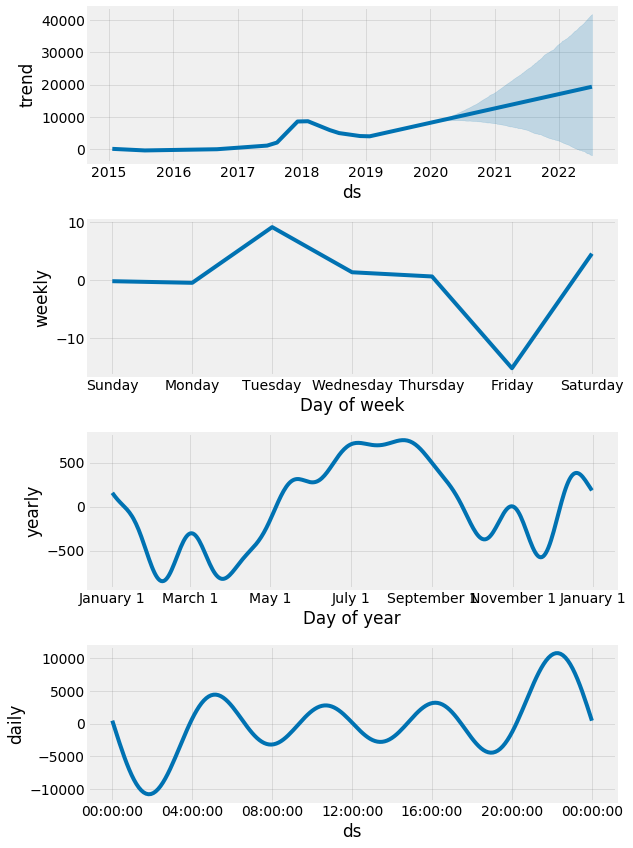

In [16]:
future_dates = my_model.make_future_dataframe(periods=900)
forecast =my_model.predict(future_dates)

fig2 = my_model.plot_components(forecast)

In [42]:
forecastnew = forecast['ds']
forecastnew2 = forecast['yhat']

forecastnew = pd.concat([forecastnew,forecastnew2], axis=1)

mask = (forecastnew['ds'] > "2020-01-19") & (forecastnew['ds'] <= "2022-01-17")
forecastedvalues = forecastnew.loc[mask]

mask = (forecastnew['ds'] > "2015-01-19") & (forecastnew['ds'] <= "2020-01-19")
forecastnew = forecastnew.loc[mask]

Red = Predicted Values, Blue = Base Values


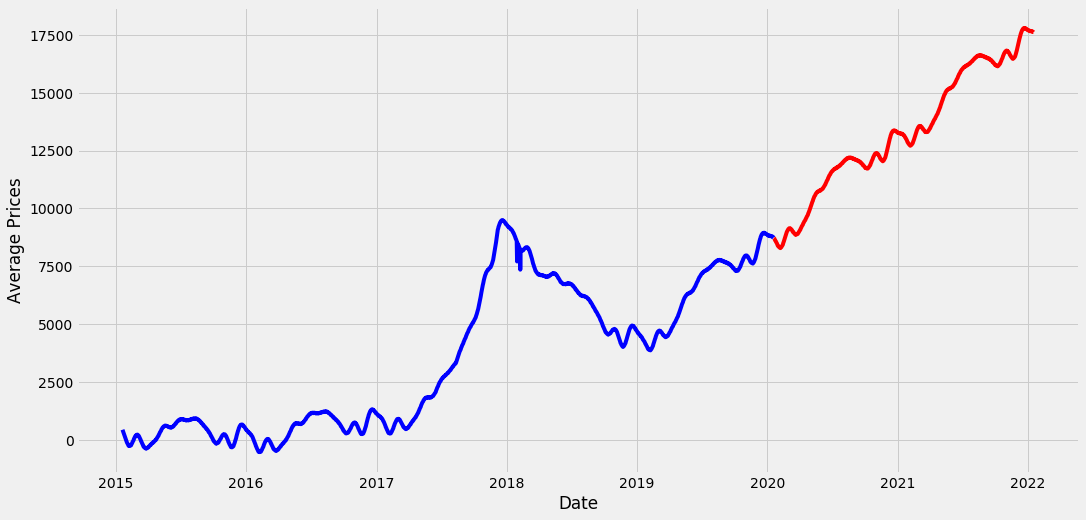

In [43]:
fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.plot(forecastnew.set_index('ds'), color='b')
ax1.plot(forecastedvalues.set_index('ds'), color='r')
ax1.set_ylabel('Average Prices')
ax1.set_xlabel('Date')
print("Red = Predicted Values, Blue = Base Values")

In [32]:
#Date input from user for testing
print("Please add 1 hour to the `to` input to make sure that you always get data for the end date as well.")

start_date = str(input('Enter a start date in YYYY-MM-DD-H-M (2021-12-27-14-41) format'))
end_date = str(input('Enter a end date in YYYY-MM-DD-H-M (2021-12-27-14-41) format'))

Please add 1 hour to the `to` input to make sure that you always get data for the end date as well.


Enter a start date in YYYY-MM-DD-H-M (2021-12-27-14-41) format 2020-01-19-00-00
Enter a end date in YYYY-MM-DD-H-M (2021-12-27-14-41) format 2022-01-21-01-00


In [60]:
test_data=get_bitcoin_data_df(start_date, end_date)
test_data=test_data.reset_index()
test_data=test_data["prices"]
test_data

the bitcoin data between 2020-01-19-00-00 and 2022-01-21-01-00 dates is being obtained


0       8030.890983
1       7833.230953
2       7778.071763
3       7870.658880
4       7810.331599
           ...     
724    37634.149717
725    38443.019606
726    37184.998544
727    37774.601606
728    37867.280489
Name: prices, Length: 729, dtype: float64

In [72]:
y_pred=forecastedvalues["yhat"]
y_pred=y_pred.reset_index()
y_pred.drop(axis=1,columns="index",inplace=True)
y_pred

,yhat
0,8715.164383
1,8703.056527
2,8671.037911
3,8643.825890
4,8599.484730
...,...
724,17647.744174
725,17625.297571
726,17636.728274
727,17621.510777


In [74]:
# The mean absolute error
print("MAE = %5.3f" % mean_absolute_error(test_data, y_pred))
# Explained variance score: 1 is perfect prediction
print("R^2 = %0.5f" % r2_score(test_data, y_pred))
# The mean squared error
print("MSE = %5.3f" % mean_squared_error(test_data, y_pred))
# Root-Mean-Squared-Error (RMSE)
print("RMSE = %5.3f" % rmse(test_data, y_pred))

MAE = 14110.175
R^2 = -0.31159
MSE = 360542274.457
RMSE = 20809.930


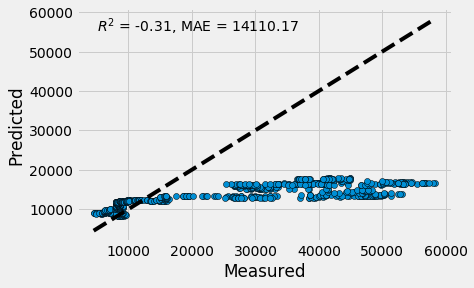

In [76]:
fig, ax = plt.subplots()
ax.scatter(test_data, y_pred, edgecolors = (0, 0, 0))
ax.text(5000,55000, r"$R^2$ = %.2f, MAE = %.2f" % (
r2_score(test_data, y_pred), mean_absolute_error(test_data, y_pred)))
ax.plot([test_data.min(), test_data.max()], [test_data.min(), test_data.max()], "k--",
lw = 4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
plt.show()

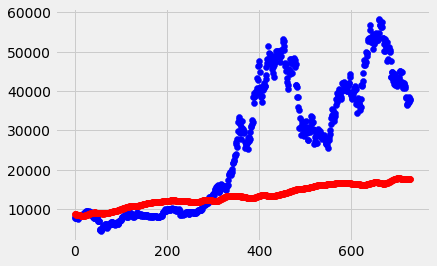

In [79]:
plt.scatter(test_data.index, test_data, color="blue")
plt.scatter(test_data.index, y_pred, color="red")
plt.show()